✅ Dataset loaded and labels encoded.
Class distribution (original):
Human Values Violation
1    11127
0     7106
Name: count, dtype: int64


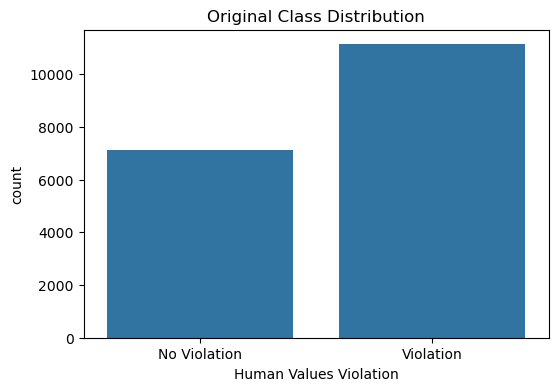

/var/folders/y0/33xgrsyx18j1bp7lv_zr_j600000gn/T/ipykernel_7891/2119475426.py:51: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


Raw train: 12762 | Val: 2736 | Test: 2735
Train class (raw): Counter({1: 7788, 0: 4974}) | Test: Counter({1: 1669, 0: 1066})
✅ After oversampling → Train size: 15576 | Class: Counter({1: 7788, 0: 7788})
Using device: mps

🚀 Starting BERT training...

Epoch 1/6


Evaluating: 100%|█████████████████████████████| 171/171 [00:30<00:00,  5.60it/s]


Train Loss: 0.2578 | Train Acc: 0.8974
Val   Loss: 0.2727 | Val   Acc: 0.9145

✅ New best model saved!
Epoch 2/6


Evaluating: 100%|█████████████████████████████| 171/171 [00:29<00:00,  5.70it/s]


Train Loss: 0.1356 | Train Acc: 0.9569
Val   Loss: 0.2109 | Val   Acc: 0.9401

✅ New best model saved!
Epoch 3/6


Evaluating: 100%|█████████████████████████████| 171/171 [00:30<00:00,  5.59it/s]


Train Loss: 0.0813 | Train Acc: 0.9771
Val   Loss: 0.2547 | Val   Acc: 0.9426

✅ New best model saved!
Epoch 4/6


Evaluating: 100%|█████████████████████████████| 171/171 [00:30<00:00,  5.66it/s]


Train Loss: 0.0581 | Train Acc: 0.9846
Val   Loss: 0.2930 | Val   Acc: 0.9477

✅ New best model saved!
Epoch 5/6


Evaluating: 100%|█████████████████████████████| 171/171 [00:30<00:00,  5.67it/s]


Train Loss: 0.0470 | Train Acc: 0.9873
Val   Loss: 0.3186 | Val   Acc: 0.9459

Epoch 6/6


Evaluating: 100%|█████████████████████████████| 171/171 [00:30<00:00,  5.60it/s]


Train Loss: 0.0352 | Train Acc: 0.9908
Val   Loss: 0.3249 | Val   Acc: 0.9455


🔍 Final evaluation on TEST SET...


Evaluating: 100%|█████████████████████████████| 171/171 [00:30<00:00,  5.62it/s]



🎯 BERT Final Test Results:
Accuracy : 0.9459
Precision: 0.9546
Recall   : 0.9569
F1-Score : 0.9557

📋 Classification Report (Test Set):
              precision    recall  f1-score   support

No Violation       0.93      0.93      0.93      1066
   Violation       0.95      0.96      0.96      1669

    accuracy                           0.95      2735
   macro avg       0.94      0.94      0.94      2735
weighted avg       0.95      0.95      0.95      2735



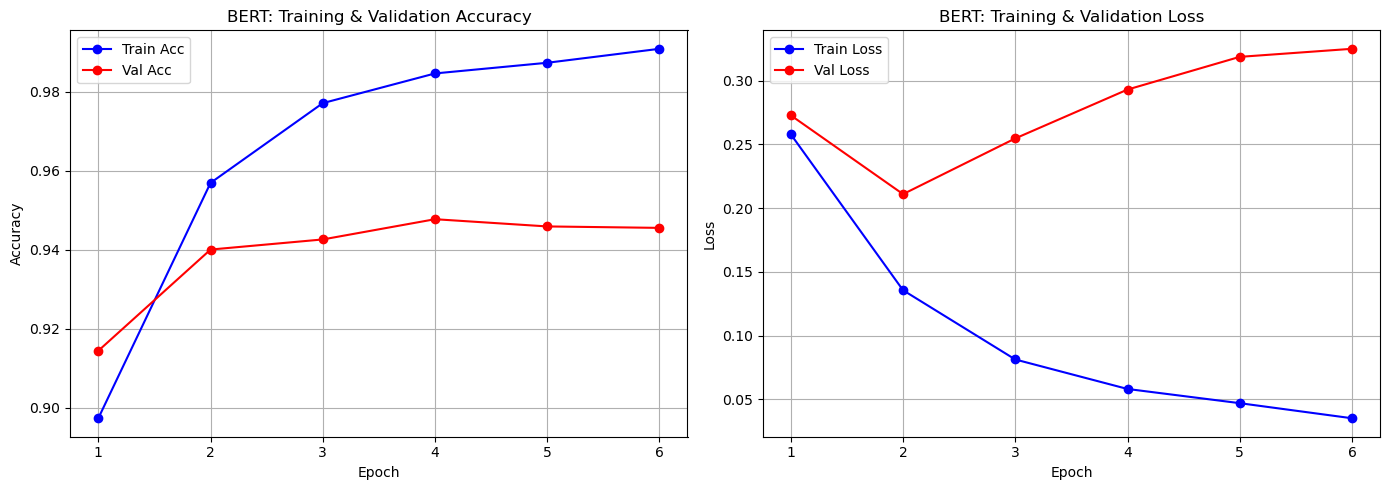

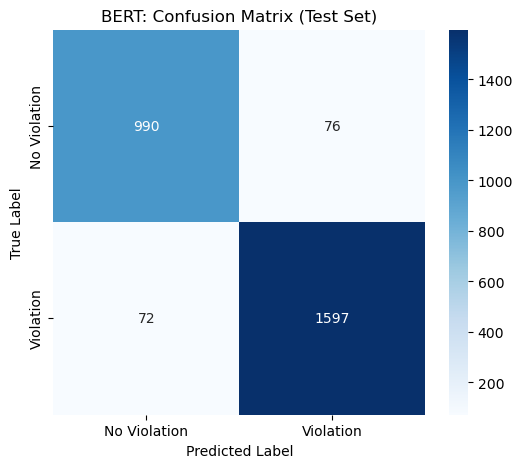

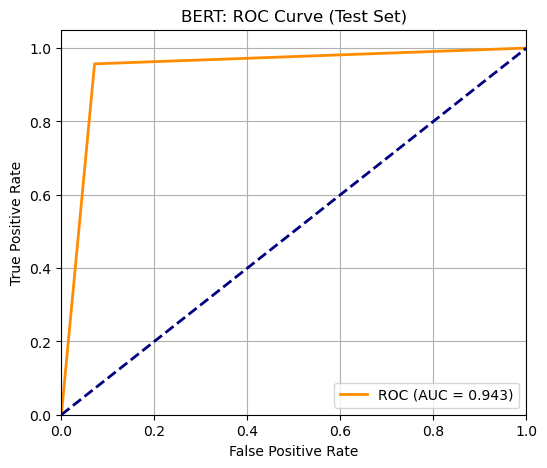

In [1]:
## Load all libraries
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
import re
from bs4 import BeautifulSoup
import contractions
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Load dataset — same as before
try:
    df = pd.read_csv('amazonbinaryclassificationdataset_transformer.csv', encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv('amazonbinaryclassificationdataset_transformer.csv', encoding='latin1')

# Rename & label encoding
df = df.rename(columns={'Base_Reviews': 'Review', 'Have_Violation': 'Human Values Violation'})

def convert_issue(issue):
    issue = str(issue).lower().strip()
    return 0 if issue in ['no', '0'] else 1

df['Human Values Violation'] = df['Human Values Violation'].apply(convert_issue)
df['Review'] = df['Review'].fillna('')

print("✅ Dataset loaded and labels encoded.")
print("Class distribution (original):")
print(df['Human Values Violation'].value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Human Values Violation')
plt.title('Original Class Distribution')
plt.xticks([0, 1], ['No Violation', 'Violation'])
plt.show()

### Preprocessing
def preprocess_review(text):
    if not isinstance(text, str):
        text = str(text)
    text = contractions.fix(text)
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = ' '.join(text.split())
    return text

df['ReviewP'] = df['Review'].apply(preprocess_review)
texts = df['ReviewP'].tolist()
labels = df['Human Values Violation'].tolist()

### ✅ STEP 1: Split raw data FIRST (stratified) — 70% train, 15% val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    texts, labels, test_size=0.15, random_state=42, stratify=labels
)
X_train_raw, X_val, y_train_raw, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
)

print(f"Raw train: {len(X_train_raw)} | Val: {len(X_val)} | Test: {len(X_test)}")
print(f"Train class (raw): {Counter(y_train_raw)} | Test: {Counter(y_test)}")

### ✅ STEP 2: Oversample ONLY train
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(
    np.array(X_train_raw).reshape(-1, 1), y_train_raw
)
X_train_res = X_train_res.flatten().tolist()

print(f"✅ After oversampling → Train size: {len(X_train_res)} | Class: {Counter(y_train_res)}")

### Dataset class
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label)
        }

### BERT Model Definition
class BERTClassifier(nn.Module):
    def __init__(self, model_name, num_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0]  # [CLS] token
        x = self.dropout(cls_output)
        logits = self.fc(x)
        return logits

# Hyperparameters
model_name = 'bert-base-uncased'  # 🚀
num_classes = 2
max_length = 128
batch_size = 16
num_epochs = 6
learning_rate = 1e-5

tokenizer = BertTokenizer.from_pretrained(model_name)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Datasets & dataloaders
train_dataset = TextClassificationDataset(X_train_res, y_train_res, tokenizer, max_length)
val_dataset = TextClassificationDataset(X_val, y_val, tokenizer, max_length)
test_dataset = TextClassificationDataset(X_test, y_test, tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, optimizer, scheduler
model = BERTClassifier(model_name, num_classes).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate)

total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

criterion = nn.CrossEntropyLoss()

### Training & Eval (same functions reused)
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for batch in tqdm(data_loader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / len(data_loader), correct / total

def evaluate_model(model, data_loader, device):
    model.eval()
    predictions, true_labels = [], []
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(true_labels, predictions)
    avg_loss = total_loss / len(data_loader)
    return avg_loss, accuracy, predictions, true_labels

# Training loop
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0.0

print("\n🚀 Starting BERT training...\n")

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)
    val_loss, val_acc, _, _ = evaluate_model(model, val_loader, device)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}\n")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'bert_best.pth')
        print("✅ New best model saved!")

# Final evaluation
model.load_state_dict(torch.load('bert_best.pth', map_location=device))
print("\n🔍 Final evaluation on TEST SET...")

test_loss, test_acc, test_preds, test_labels = evaluate_model(model, test_loader, device)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='binary')

print(f"\n🎯 BERT Final Test Results:")
print(f"Accuracy : {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")

print("\n📋 Classification Report (Test Set):")
print(classification_report(test_labels, test_preds, target_names=["No Violation", "Violation"]))

# Plotting
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, 'b-o', label='Train Acc')
plt.plot(epochs, val_accuracies, 'r-o', label='Val Acc')
plt.title('BERT: Training & Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, 'b-o', label='Train Loss')
plt.plot(epochs, val_losses, 'r-o', label='Val Loss')
plt.title('BERT: Training & Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.savefig('bert_learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Violation", "Violation"],
            yticklabels=["No Violation", "Violation"])
plt.title("BERT: Confusion Matrix (Test Set)")
plt.ylabel("True Label"); plt.xlabel("Predicted Label")
plt.savefig('bert_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(test_labels, test_preds)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('BERT: ROC Curve (Test Set)')
plt.legend(loc="lower right"); plt.grid(True)
plt.savefig('bert_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()